# Detector simulation stage
In this notebook I am simulating the propagation of the electrons in the LArTPC taking into account the recombination (quenching) and the drifting (lifetime and diffusion). Each step is implement as a PyTorch module.

In [1]:
%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import scipy.ndimage
import scipy.stats
from tqdm import tqdm_notebook
from sklearn.preprocessing import normalize
import math
import scipy.signal

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
physicalParams = {
    'MeVToElectrons': 4.237e+04,
    'alpha': 0.847,
    'beta': 0.2061
}

tpcParams = {
    'vdrift': 0.153812 * u.cm/u.us,  
    'lifetime': 10e3 * u.us,
    'tpcBorders': ((-150, 150), (-150, 150), (-150, 150)) * u.cm, 
    'longDiff': 6.2e-6 * u.cm*u.cm/u.us, 
    'tranDiff': 16.3e-6 *u.cm
}

In [5]:
tracks = pickle.load(open('tracks.p', 'rb'))

In [6]:
tracks.head()

,RunID,SubrunID,SpillID,InteractionID,trackID,PDG,x_start,x_end,y_start,y_end,z_start,z_end,dE
0,1,1,0,0,0,13,-17.442279,-1.067252,54.421781,73.017072,116.572549,141.474416,0.068951
1,1,1,0,0,1,13,-88.528219,-63.620363,-11.659430,8.987214,-131.389106,-107.043614,0.078303
2,1,1,0,0,2,13,-112.629682,-96.510055,90.832628,111.833248,-111.631318,-91.798615,0.061378
3,1,1,0,0,3,13,103.634649,119.667934,-92.306567,-76.349427,17.838484,39.695463,0.065615
4,1,1,0,0,4,13,9.430340,28.018870,-54.496824,-39.147939,-87.729923,-66.618393,0.065586


## Tracks loading
Here we load some simulated tracks from a text file and we store them in a PyTorch tensor

In [7]:
tracks['t'] = 0
tracks['t_start'] = 0
tracks['t_end'] = 0

In [8]:
tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) + 
                       pow(tracks['y_end']-tracks['y_start'], 2) +
                       pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2 
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']

ix = tracks.columns.get_loc("x")
ixStart = tracks.columns.get_loc("x_start")
ixEnd = tracks.columns.get_loc("x_end")
iyStart = tracks.columns.get_loc("y_start")
iyEnd = tracks.columns.get_loc("y_end")
izStart = tracks.columns.get_loc("z_start")
izEnd = tracks.columns.get_loc("z_end")
itStart = tracks.columns.get_loc("t_start")
itEnd = tracks.columns.get_loc("t_end")

iy = tracks.columns.get_loc("y")
it = tracks.columns.get_loc("t")
iz = tracks.columns.get_loc("z")
idE = tracks.columns.get_loc("dE")
idx = tracks.columns.get_loc("dx")
idEdx = tracks.columns.get_loc("dEdx")
iTrackId = tracks.columns.get_loc("trackID")

iNElectrons = len(tracks.columns)
iLongDiff = len(tracks.columns)+1
iTranDiff = len(tracks.columns)+2

print("We have %i tracks" % len(tracks))

We have 2000 tracks


In [9]:
segment_size = 1

x = []
y = []
z = []
t = []
trackId = []
dE = []

for i in tqdm_notebook(range(len(tracks))):
    x_start = tracks['x_start'][i]
    x_end = tracks['x_end'][i]

    y_start = tracks['y_start'][i]
    y_end = tracks['y_end'][i]

    z_start = tracks['z_start'][i]
    z_end = tracks['z_end'][i]

    d = np.array([x_end-x_start, y_end-y_start, z_end-z_start])
    p = np.array([x_start, y_start, z_start])
    e = np.array([x_end, y_end, z_end])
    d /= np.linalg.norm(d)

    s = p - segment_size*d/2
    track_dx = tracks['dx'][i]
    
    n_segments = math.floor(track_dx/segment_size)

    for j in range(1, n_segments):
        s = p + j*segment_size*d
        x.append(s[0])
        y.append(s[1])
        z.append(s[2])
        t.append(0)
        dE.append(tracks['dE'][i] / (n_segments-1))
        trackId.append(tracks['trackID'][i])
        
segmentedTracks = {'x': x, 'y': y, 'z': z,
                   't': t, 'trackId': trackId, 'dE': dE}

In [10]:
segmentedTracks = pd.DataFrame.from_dict(tracks)

# segmentedTracks['dEdx'] = segmentedTracks['dE']/segment_size

ix = segmentedTracks.columns.get_loc("x")
iy = segmentedTracks.columns.get_loc("y")
iz = segmentedTracks.columns.get_loc("z")
it = segmentedTracks.columns.get_loc("t")
idE = segmentedTracks.columns.get_loc("dE")
idEdx = segmentedTracks.columns.get_loc("dEdx")
# iTrackId = segmentedTracks.columns.get_loc("trackId")

iNElectrons = len(segmentedTracks.columns)
iLongDiff = len(segmentedTracks.columns)+1
iTranDiff = len(segmentedTracks.columns)+2

In [11]:
# %%timeit
# torch.tensor(tracks.values).to(device)

In [12]:
# I need to repeat this because of %%timeit bug https://github.com/jupyter/notebook/issues/4532
segmentedTracks = torch.tensor(segmentedTracks.values).to(device) 

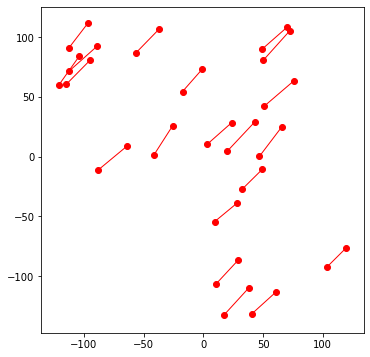

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
x_edges = y_edges = np.linspace(-150, 150, 31)
sum_values = np.zeros((30,30))
np.set_printoptions(precision=1)

for i in range(20):
    m = (tracks['y_start'][i]-tracks['y_end'][i])/(tracks['x_start'][i]-tracks['x_end'][i])
    q = tracks['y_start'][i]-m*tracks['x_start'][i]
    x_length = np.abs(tracks['x_start'][i]-tracks['x_end'][i])
    x = np.linspace(tracks['x_start'][i], tracks['x_end'][i], np.ceil(x_length/10*10).astype('int32'))
    y = m*x+q
    
    ax.plot(x, y, c='r', lw=1)
#     print(math.floor(x[0]), x[0])
    padding = 10
    x_edges = np.linspace(tracks['x_start'][i]-padding, tracks['x_end'][i]+padding, np.ceil((x_length+padding)/10*10).astype('int32'))
    y_edges = m*x_edges + q
    bin_values, _, __ = np.histogram2d(x,y,bins=(x_edges, y_edges) )
#     print(bin_values)
#     print(scipy.ndimage.gaussian_filter(bin_values,
#                                         sigma=[0.2, 0.2]))


#     print(np.vstack(np.nonzero(bin_values)).transpose())
#     sum_values += bin_values
    
    ax.scatter((tracks['x_start'][i], tracks['x_end'][i]), (tracks['y_start'][i], tracks['y_end'][i]), c='r' )


sum_values[sum_values>0] = 1

X, Y = np.meshgrid(x_edges,y_edges)
# ax.pcolormesh(X, Y, sum_values.T,zorder=0)
ax.set_aspect('equal')


## Quenching stage
This class implements the recombination simulation of the ionized electrons. It adds a new column to the tensor with the number of ionized electrons generated by each track segment. 

In [14]:
class Quenching(torch.nn.Module):
    """
    PyTorch module which implements the quenching of the electrons
    in the TPC. 
    """
    
    def forward(self, x):
        """The number of electrons ionized by the track segment is calculated
        taking into account the recombination.
        
        Returns":
            x: a new tensor with an additional column for the number of ionized
            electrons
        """

        add_columns = torch.nn.ZeroPad2d((0, 1, 0, 0))
        x = add_columns(x)

        recomb = torch.log(physicalParams['alpha'] + physicalParams['beta'] * x[:,idEdx]) / (physicalParams['beta'] * x[:,idEdx])
        recomb = torch.where(recomb<=0, torch.zeros_like(recomb), recomb)
        recomb = torch.where(torch.isnan(recomb), torch.zeros_like(recomb), recomb)
        x[:,iNElectrons] = physicalParams['MeVToElectrons'] * x[:,idE] * recomb
        return x

In [15]:
# %%timeit
# quenching = Quenching()
# quenching(segmentedTracks)

In [16]:
# I need to repeat this because of %%timeit bug https://github.com/jupyter/notebook/issues/4532
quenching = Quenching()
quenchedTracks = quenching(segmentedTracks)

## Drifting stage
This class implements the drifting simulation of the ionized electrons, taking into account electron lifetime and diffusion. It adds two new columns to the tensor, corresponding to the transverse and longitudinal diffusion coefficients.

In [17]:
class Drifting(torch.nn.Module):
    """
    PyTorch module which implements the propagation of the
    electrons towards the anode. 
    """
    
    def forward(self, x):
        """The z coordinate of the track segment is set to 
        the z coordinate of the anode. 
        The number of electrons is corrected by the electron lifetime. 
        The longitudinal and transverse diffusion factors are calculated.
        The time is set to the drift time, calculated taking into account the transverse 
        diffusion factor
        
        Returns:
            x: a new tensor with 2 additional column, for the longitudinal
            diffusion and transverse diffusion coefficients
        """
        
        add_columns = torch.nn.ZeroPad2d((0, 2, 0, 0))
        x = add_columns(x)
        
        zStart =  tpcParams['tpcBorders'][2][0].value

        driftDistance = torch.abs(x[:,iz] - zStart)
        driftStart = torch.abs(x[:,izStart] - zStart)
        driftEnd = torch.abs(x[:,izEnd] - zStart)

        driftTime = driftDistance / tpcParams['vdrift'].value
        x[:,iz] = zStart
        
        lifetime = torch.exp(-driftTime / tpcParams['lifetime'].value)
        x[:,iNElectrons] = x[:,iNElectrons] * lifetime
        
        x[:,iLongDiff] = torch.sqrt(driftTime) * tpcParams['longDiff'].value
        x[:,iTranDiff] = torch.sqrt(driftTime) * tpcParams['tranDiff'].value
        x[:,it] += driftTime + x[:,iTranDiff] / tpcParams['vdrift'].value
        x[:,itStart] += driftStart + x[:,iTranDiff] / tpcParams['vdrift'].value
        x[:,itEnd] += driftEnd + x[:,iTranDiff] / tpcParams['vdrift'].value

        return x

In [18]:
# %%timeit
# drifting = Drifting()
# drifting(quenchedTracks)

In [19]:
# I need to repeat this because of %%timeit bug https://github.com/jupyter/notebook/issues/4532
drifting = Drifting()
driftedTracks = drifting(quenchedTracks)

In [20]:
electron_bins_x = np.linspace(-150,150,150)
electron_bins_y = np.linspace(-150,150,150)
electron_bins_t = np.linspace(-2000,2000,1000)
t_binning = electron_bins_t[1]-electron_bins_t[0]

selectedTracks = driftedTracks[driftedTracks[:,iTrackId] < 100]

In [21]:
chargeMapDiffused = np.zeros((len(electron_bins_x),len(electron_bins_y),len(electron_bins_t)))
electronMap = np.zeros((len(electron_bins_x),len(electron_bins_y),len(electron_bins_t)))
chargeMap = np.zeros((len(electron_bins_x),len(electron_bins_y),len(electron_bins_t)))

trackBins = np.array((5,5,5))
binCenters = np.floor(trackBins/2).astype("int32")

for t in tqdm_notebook(selectedTracks):
    bin_x = np.digitize(t[ix], bins=electron_bins_x)
    bin_y = np.digitize(t[iy], bins=electron_bins_y)
    bin_t = np.digitize(t[it], bins=electron_bins_t)

    charge = np.zeros(trackBins)
    charge[binCenters[0],binCenters[1],binCenters[2]] = t[iNElectrons]

    smooth = scipy.ndimage.gaussian_filter(charge,
                                           sigma=[t[iTranDiff].item()*2000, 
                                                  t[iTranDiff].item()*2000, 
                                                  t[iLongDiff].item()*5000])

    chargeMap[bin_x-binCenters[0]:bin_x+binCenters[0]+1,
              bin_y-binCenters[1]:bin_y+binCenters[1]+1,
              bin_t-binCenters[2]:bin_t+binCenters[2]+1] += charge
    
    chargeMapDiffused[bin_x-binCenters[0]:bin_x+binCenters[0]+1,
                      bin_y-binCenters[1]:bin_y+binCenters[1]+1,
                      bin_t-binCenters[2]:bin_t+binCenters[2]+1] += smooth

## Drawing a line in a 3D array

Here we draw a 3D line inside a 3D array using `skimage.draw.line_nd`. We can then use `scipy.ndimage.gaussian_filter` on this 3D array to apply the transverse and longitudinal diffusion. The 

In [984]:
sampling = 0.5
anode_x = np.linspace(-150,150,int(300/sampling))

t_sampling = 0.05
anode_t = np.linspace(0,300,int(300/t_sampling))

def trackPixels(tracks, trackId, anode):
    t = tracks[trackId]
    x1,y1,t1 = t[ixStart], t[iyStart], t[itStart]
    x2,y2,t2 = t[ixEnd], t[iyEnd], t[itEnd]
    
    x_size = math.ceil((x2-x1)/sampling)
    y_size = math.ceil((y2-y1)/sampling)
    t_size = math.ceil((t2-t1)/t_sampling)

    l = line_nd((0,0,0), ((x2-x1)/sampling,(y2-y1)/sampling,(t2-t1)/t_sampling),endpoint=True)
    img = np.zeros((x_size+1,y_size+1,t_size+1), dtype=np.float32)
    img[l] = t[iNElectrons]/len(l[0])
    img = np.pad(img, 
                 ((math.ceil(1/sampling),math.ceil(1/sampling)),
                  (math.ceil(1/sampling),math.ceil(1/sampling)),
                  (math.ceil(1/t_sampling),math.ceil(1/t_sampling))), 
                 mode='constant')

    img = scipy.ndimage.gaussian_filter(img, sigma=(t[iTranDiff].item()*2000,
                                                    t[iTranDiff].item()*2000,
                                                    t[iLongDiff].item()*1000))

    x_bin = np.digitize(x1, anode_x)
    y_bin = np.digitize(y1, anode_x)
    t_bin = np.digitize(t1, anode_t)

    anode[x_bin-1:x_bin+x_size+2*math.ceil(1/sampling),
          y_bin-1:y_bin+y_size+2*math.ceil(1/sampling),
          t_bin-1:t_bin+t_size+2*math.ceil(1/t_sampling)] = img
    
    return img

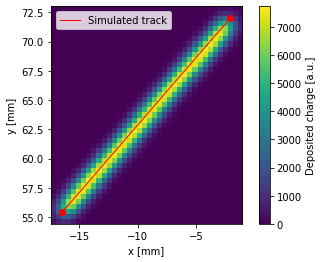

In [985]:
tpc = np.zeros((int(300/sampling),int(300/sampling),int(300/t_sampling)))
trackId = 0
trackImg = trackPixels(driftedTracks, trackId, tpc)
fig, ax = plt.subplots(1,1)
im = ax.imshow(trackImg.sum(axis=2).T,
           origin='low',
           label='Charge at anode after diffusion',
           extent=(driftedTracks[trackId][ixStart],driftedTracks[trackId][ixEnd],driftedTracks[trackId][iyStart],driftedTracks[trackId][iyEnd]))

ax.plot((driftedTracks[trackId][ixStart]+1,driftedTracks[trackId][ixEnd]-1),
         (driftedTracks[trackId][iyStart]+1,driftedTracks[trackId][iyEnd]-1),
         lw=1,
         c='r',
         label='Simulated track')
ax.scatter((driftedTracks[trackId][ixStart].item()+1,driftedTracks[trackId][ixEnd].item()-1),
           (driftedTracks[trackId][iyStart].item()+1,driftedTracks[trackId][iyEnd].item()-1),
           c='r')
ax.legend()
plt.colorbar(im, label='Deposited charge [a.u.]')
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_aspect('equal')
fig.savefig('diff.png',transparent=True)
# fig, ax = plt.subplots(1,1)
# ax.plot(trackImg.sum(axis=0).sum(axis=0))


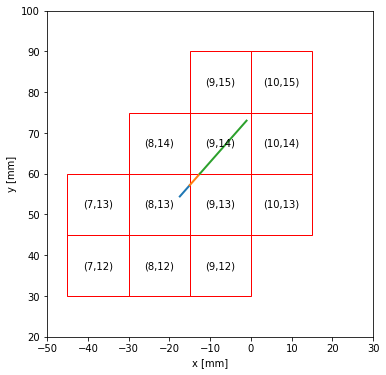

In [986]:
from shapely.geometry import MultiLineString, LineString

n_pixels = 20
def getPixels(track):
    n = n_pixels+1

    lines = []
    binx = np.linspace(-150, 150, n)
    biny = np.linspace(-150, 150, n)
    
    for x in binx:
        lines.append(((x, y0), (x, y1)))

    for y in biny:
        lines.append(((x0, y), (x1, y)))
        
    grid = MultiLineString(lines)
    
    xx = np.linspace(track[ixStart], track[ixEnd], int(track[ixEnd]-track[ixStart])*100)
    m = (track[iyEnd]-track[iyStart])/(track[ixEnd]-track[ixStart])
    q = (track[ixEnd]*track[iyStart]-track[ixStart]*track[iyEnd])/(track[ixEnd]-track[ixStart])
    yy = m*xx+q
    line = LineString(np.c_[xx, yy])
    means_x = []
    means_y = []
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    for i, segment in enumerate(line.difference(grid)):
        x, y = segment.xy
        ax.plot(x,y,lw=2)
        means_x.append(np.mean(x))
        means_y.append(np.mean(y))


    binned = scipy.stats.binned_statistic_2d(means_x, means_y, means_x, 'count', bins=[binx,biny])

    activePixels = np.nonzero(binned[0])

    xx,yy = activePixels
    involvedPixels = []

    for x,y in zip(xx,yy):
        neighbors = (x,y), (x,y+1), (x+1,y), (x,y-1), (x-1,y), (x+1,y+1), (x-1,y-1)
        for ne in neighbors:
            if ne not in involvedPixels:
                involvedPixels.append(ne)

    ax.set_xlim(-50,30)
    ax.set_ylim(20,100)
    ax.set_aspect('equal')
    for p in involvedPixels:
        rect = plt.Rectangle((p[0]*15-150,p[1]*15-150),15,15,
                             linewidth=1,
                             edgecolor='r', 
                             facecolor='none', label='Pixel')
        ax.add_patch(rect)
        ax.text(p[0]*15+7.5-150,p[1]*15+7.5-150,"(%i,%i)" % (p[0],p[1]),
                 horizontalalignment='center',
                 verticalalignment='center')
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    fig.savefig("pixels.png",transparent=True)
    return involvedPixels

pixs = getPixels(driftedTracks[0])

In [993]:
pixel_size = 300/n_pixels

def inducedCurrent(x=0, y=0, t=0):
    A = 1
    B = 5
    t0 = 150
    distance = 1#np.sqrt((x-pixel_size/2)**2+(y-pixel_size/2)**2)
    result = np.heaviside(-t+t0,0.5) * A * np.exp((1+distance)*(t-t0)/B)
    result = np.nan_to_num(result)
    return result

x_range = y_range = np.linspace(0, pixel_size, int(pixel_size/sampling))
t_range = anode_t

x_r, y_r, t_r = np.meshgrid(x_range, y_range, t_range)
i = inducedCurrent(x_r, y_r, t_r)

def plotPixels(pixels):
    fig, ax = plt.subplots(2,4, figsize=(16,8), constrained_layout=True)
    iax = 0
    px_bin = int(pixel_size/sampling)
    for x,y in pixels:
        pixel = tpc[x*px_bin:(x+1)*px_bin,y*px_bin:(y+1)*px_bin]
        if pixel.any():
            conv3d = scipy.signal.fftconvolve(i, pixel, mode='same')
            depCharge = pixel.sum(axis=0).sum(axis=0)*1e4
            indCurrent = conv3d.sum(axis=0).sum(axis=0)
            ax[int(iax/4)][iax%4].plot(t_range, depCharge, label="Deposited charge $\cdot$ 1e4")
            ax[int(iax/4)][iax%4].plot(t_range, indCurrent, label="Current")
            ax[int(iax/4)][iax%4].set_xlim(max(0, t_range[depCharge>0][0]-10), 
                                           min(300, t_range[depCharge>0][-1]+10))
            ax[int(iax/4)][iax%4].set_title("Pixel (%i,%i)" % (x,y))
            ax[int(iax/4)][iax%4].set_xlabel("Time [$\mu$s]")
            iax+=1 
    ax[0][0].legend()
    fig.delaxes(ax.flatten()[-1])
    fig.savefig("pixels.pdf")

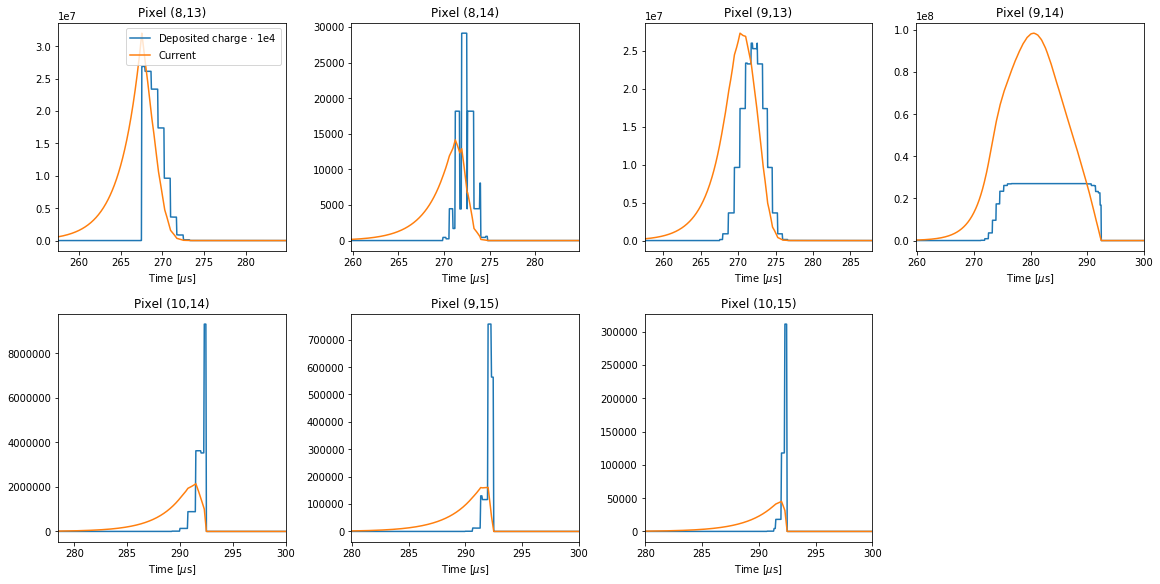

In [994]:
plotPixels(pixs)

## Pixelating the collected charge
Here we use `numpy.reshape` to assign the collected charge to each pixel.

In [578]:
def shrink2d(data, rows, cols):
    return data.reshape(rows, int(data.shape[0]/rows), cols, int(data.shape[1]/cols), data.shape[2]).sum(axis=1).sum(axis=2)

In [590]:
shrinkedTPC = shrink2d(tpc, 20, 20)
pixels = np.sum(shrinkedTPC, axis=2)
anode = np.sum(tpc,axis=2)

In [591]:
activePixels = np.nonzero(pixels)
xx, yy = activePixels

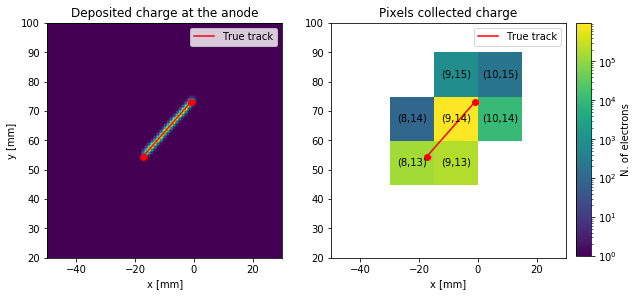

In [593]:
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
from matplotlib.colors import LogNorm

ax[0].imshow(anode.T,extent=(-150,150,-150,150),origin='low')
ax[0].set_title("Deposited charge at the anode")
ax[1].set_title("Pixels collected charge")
ax[0].set_ylabel("y [mm]")
ax[0].set_xlabel("x [mm]")
ax[1].set_xlabel("x [mm]")
im = ax[1].imshow(pixels.T,extent=(-150,150,-150,150),origin='low',norm=LogNorm(vmin=1, vmax=np.max(pixels)))

x_start, x_end = driftedTracks[0][ixStart].item(),driftedTracks[0][ixEnd].item()
y_start, y_end = driftedTracks[0][iyStart].item(),driftedTracks[0][iyEnd].item()

ax[0].scatter((x_start, x_end), (y_start, y_end), c='r')
ax[0].plot((x_start, x_end), (y_start, y_end), c='r', label='True track')
ax[1].scatter((x_start, x_end), (y_start, y_end), c='r')
ax[1].plot((x_start, x_end), (y_start, y_end), c='r', label='True track')

ax[0].set_xlim(-50,30)
ax[0].set_ylim(20,100)
ax[1].set_xlim(-50,30)
ax[1].set_ylim(20,100)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
cax = fig.add_axes([ax[1].get_position().x1+0.1,
                    ax[1].get_position().y0-0.026,0.025,
                    ax[1].get_position().height*1.15])

plt.colorbar(im,cax=cax,label='N. of electrons')

for x, y in zip(xx, yy):
    ax[1].text(x*15+7.5-150, y*15+7.5-150, "(%i,%i)" % (x,y), 
               horizontalalignment='center',
               verticalalignment='center')
    
_ = ax[1].legend()
_ = ax[0].legend()

## Induced current parametrization

We can parametrize the current induced by the collected charge as:

\begin{equation}
i(t) = H(t-t_0) \cdot A \cdot \exp(B(t-t_0))
\end{equation}

In [559]:
def i(t, t0, A, B):
    result = np.heaviside(-t+t0,0.5) * A * np.exp((t-t0)*B)
    result[np.isnan(result)] = 0
    return result

In [560]:
A = 1
B = 1/5

## Pixel induced current
The current induced on each pixel as a function of the time is given by the convolution of the induced current function with the deposited charge. Here we are assuming (wrongly) that the induced current does not depend on the position of the charge within the pixel.

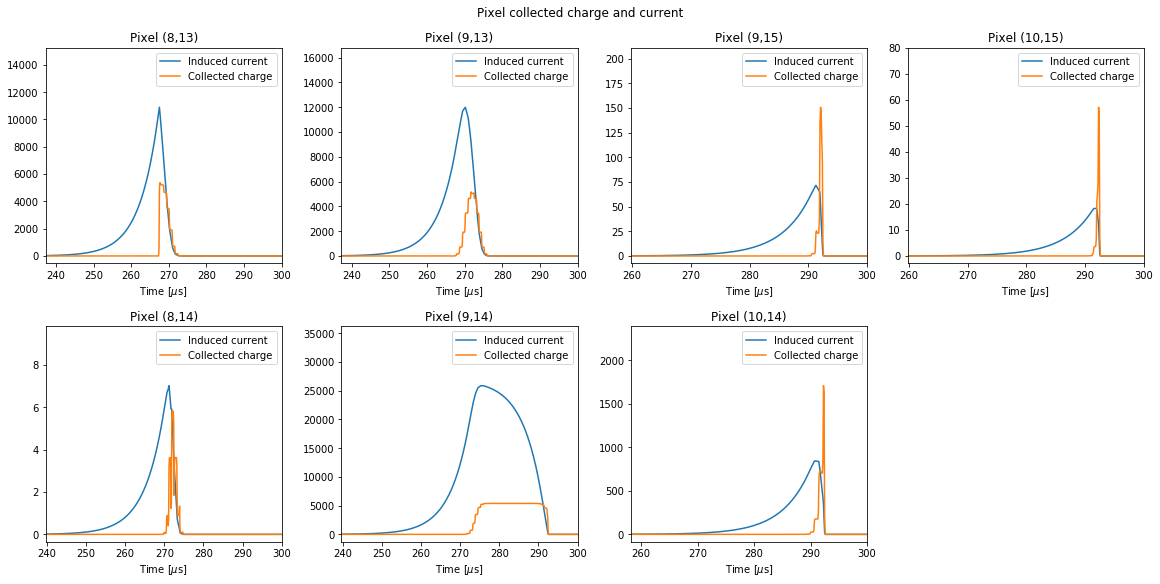

In [561]:
fig, ax = plt.subplots(2, math.ceil(len(xx)/2), figsize=(4*math.ceil(len(xx)/2),8), constrained_layout=True)

for ix, x in enumerate(xx):
    axx, axy = (ix % 2), int(ix/2)
    y = yy[ix]
    induced_current = scipy.signal.fftconvolve(shrinkedTPC[x][y], i(anode_t, 0, A, B), mode='same')*t_sampling
    ax[axx][axy].plot(anode_t, induced_current, label='Induced current')
    ax[axx][axy].plot(anode_t, shrinkedTPC[x][y], label='Collected charge')
    ax[axx][axy].legend()
    ax[axx][axy].set_xlim(max(0,anode_t[shrinkedTPC[x][y]>0][0]-30), min(anode_t[shrinkedTPC[x][y]>0][-1]+30, 300))
    ax[axx][axy].set_ylim(top=max(max(induced_current), max(shrinkedTPC[x][y]))*1.4)
    ax[axx][axy].set_xlabel("Time [$\mu$s]")
    ax[axx][axy].set_title("Pixel (%i,%i)" % (x, y))
    
fig.delaxes(ax.flatten()[-1])
_ = fig.suptitle("Pixel collected charge and current")

## Tests
### 3D tracks
This plot shows a 3D scatter plot of the simulated tracks and their drifted position at the anode (z = -150 cm).

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    ttrack = segmentedTracks[segmentedTracks[:,iTrackId] == i]
    driftedTrack = driftedTracks[driftedTracks[:,iTrackId] == i]

    plotTrack = ax.scatter(ttrack[:,ix].cpu().numpy(),
                           ttrack[:,iy].cpu().numpy(),
                           ttrack[:,iz].cpu().numpy())

    plotTrack = ax.scatter(driftedTrack[:,ix].cpu().numpy(),
                           driftedTrack[:,iy].cpu().numpy(),
                           driftedTrack[:,iz].cpu().numpy(), 
                           color=plotTrack.get_facecolor(),
                           alpha=0.01)
    
ax.set_xlim(tpcParams['tpcBorders'][0].value)
ax.set_ylim(tpcParams['tpcBorders'][1].value)
ax.set_zlim(tpcParams['tpcBorders'][2].value)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")
fig.tight_layout()

### Electron lifetime plot
This plot shows the difference between the electrons after the quenching and the electrons at the anode. The difference is caused by the finite electron lifetime.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

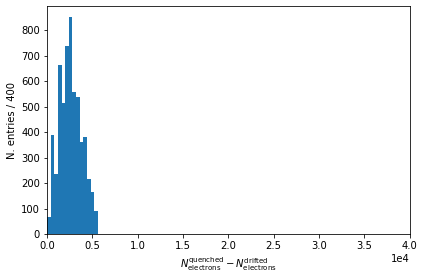

In [26]:
fig, ax = plt.subplots(1,1)
# ax.set_xlim(0,2e4)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.set_xlabel(r"$N_{\mathrm{electrons}}^{\mathrm{quenched}}-N_{\mathrm{electrons}}^{\mathrm{drifted}}$")
ax.hist(quenchedTracks[:,iNElectrons].cpu().numpy()-driftedTracks[:,iNElectrons].cpu().numpy(), bins=100, range=(0,4e4))
ax.set_xlim(left=0, right=4e4)
ax.set_ylabel("N. entries / %g" % (4e4/100))
fig.tight_layout()

### Transverse diffusion plot
This plot shows that tracks generated at a greater distance from the anode have a larger transverse diffusion coefficient, as expected.

In [51]:
fig, ax = plt.subplots(1,1)
ax.set_ylim(0,0.0010)
ax.set_xlim(tpcParams['tpcBorders'][2][0].value, tpcParams['tpcBorders'][2][1].value)
ax.set_xlabel("Start z [cm]")
ax.set_ylabel("Transverse diffusion coefficient")
_ = ax.scatter(quenchedTracks[:,iz].cpu().numpy(), driftedTracks[:,iTranDiff].cpu().numpy())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …